In [129]:
import pandas as pd
import seaborn

df = pd.read_csv("../Donnees/cleaned_data.csv")


<Axes: ylabel='Frequency'>

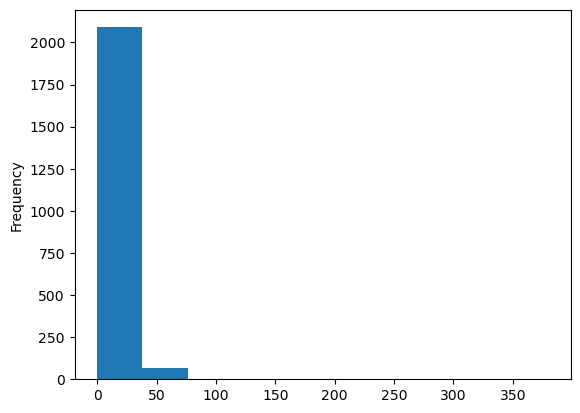

In [2]:
df["price"].plot.hist()

<Axes: >

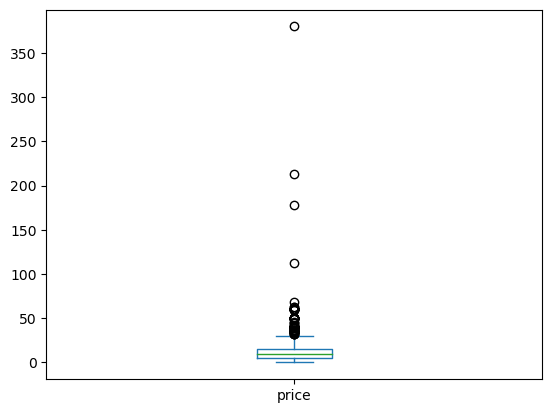

In [3]:
df["price"].plot.box()

In [4]:
number_columns = ["rating", "retirement", "time", "price", "review_count", "rating_value", "twenty_four_hours", "all_time"]
dfn = df[number_columns]

In [5]:
from sklearn.ensemble import IsolationForest

forest = IsolationForest()
outliers = forest.fit_predict(dfn)



c:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

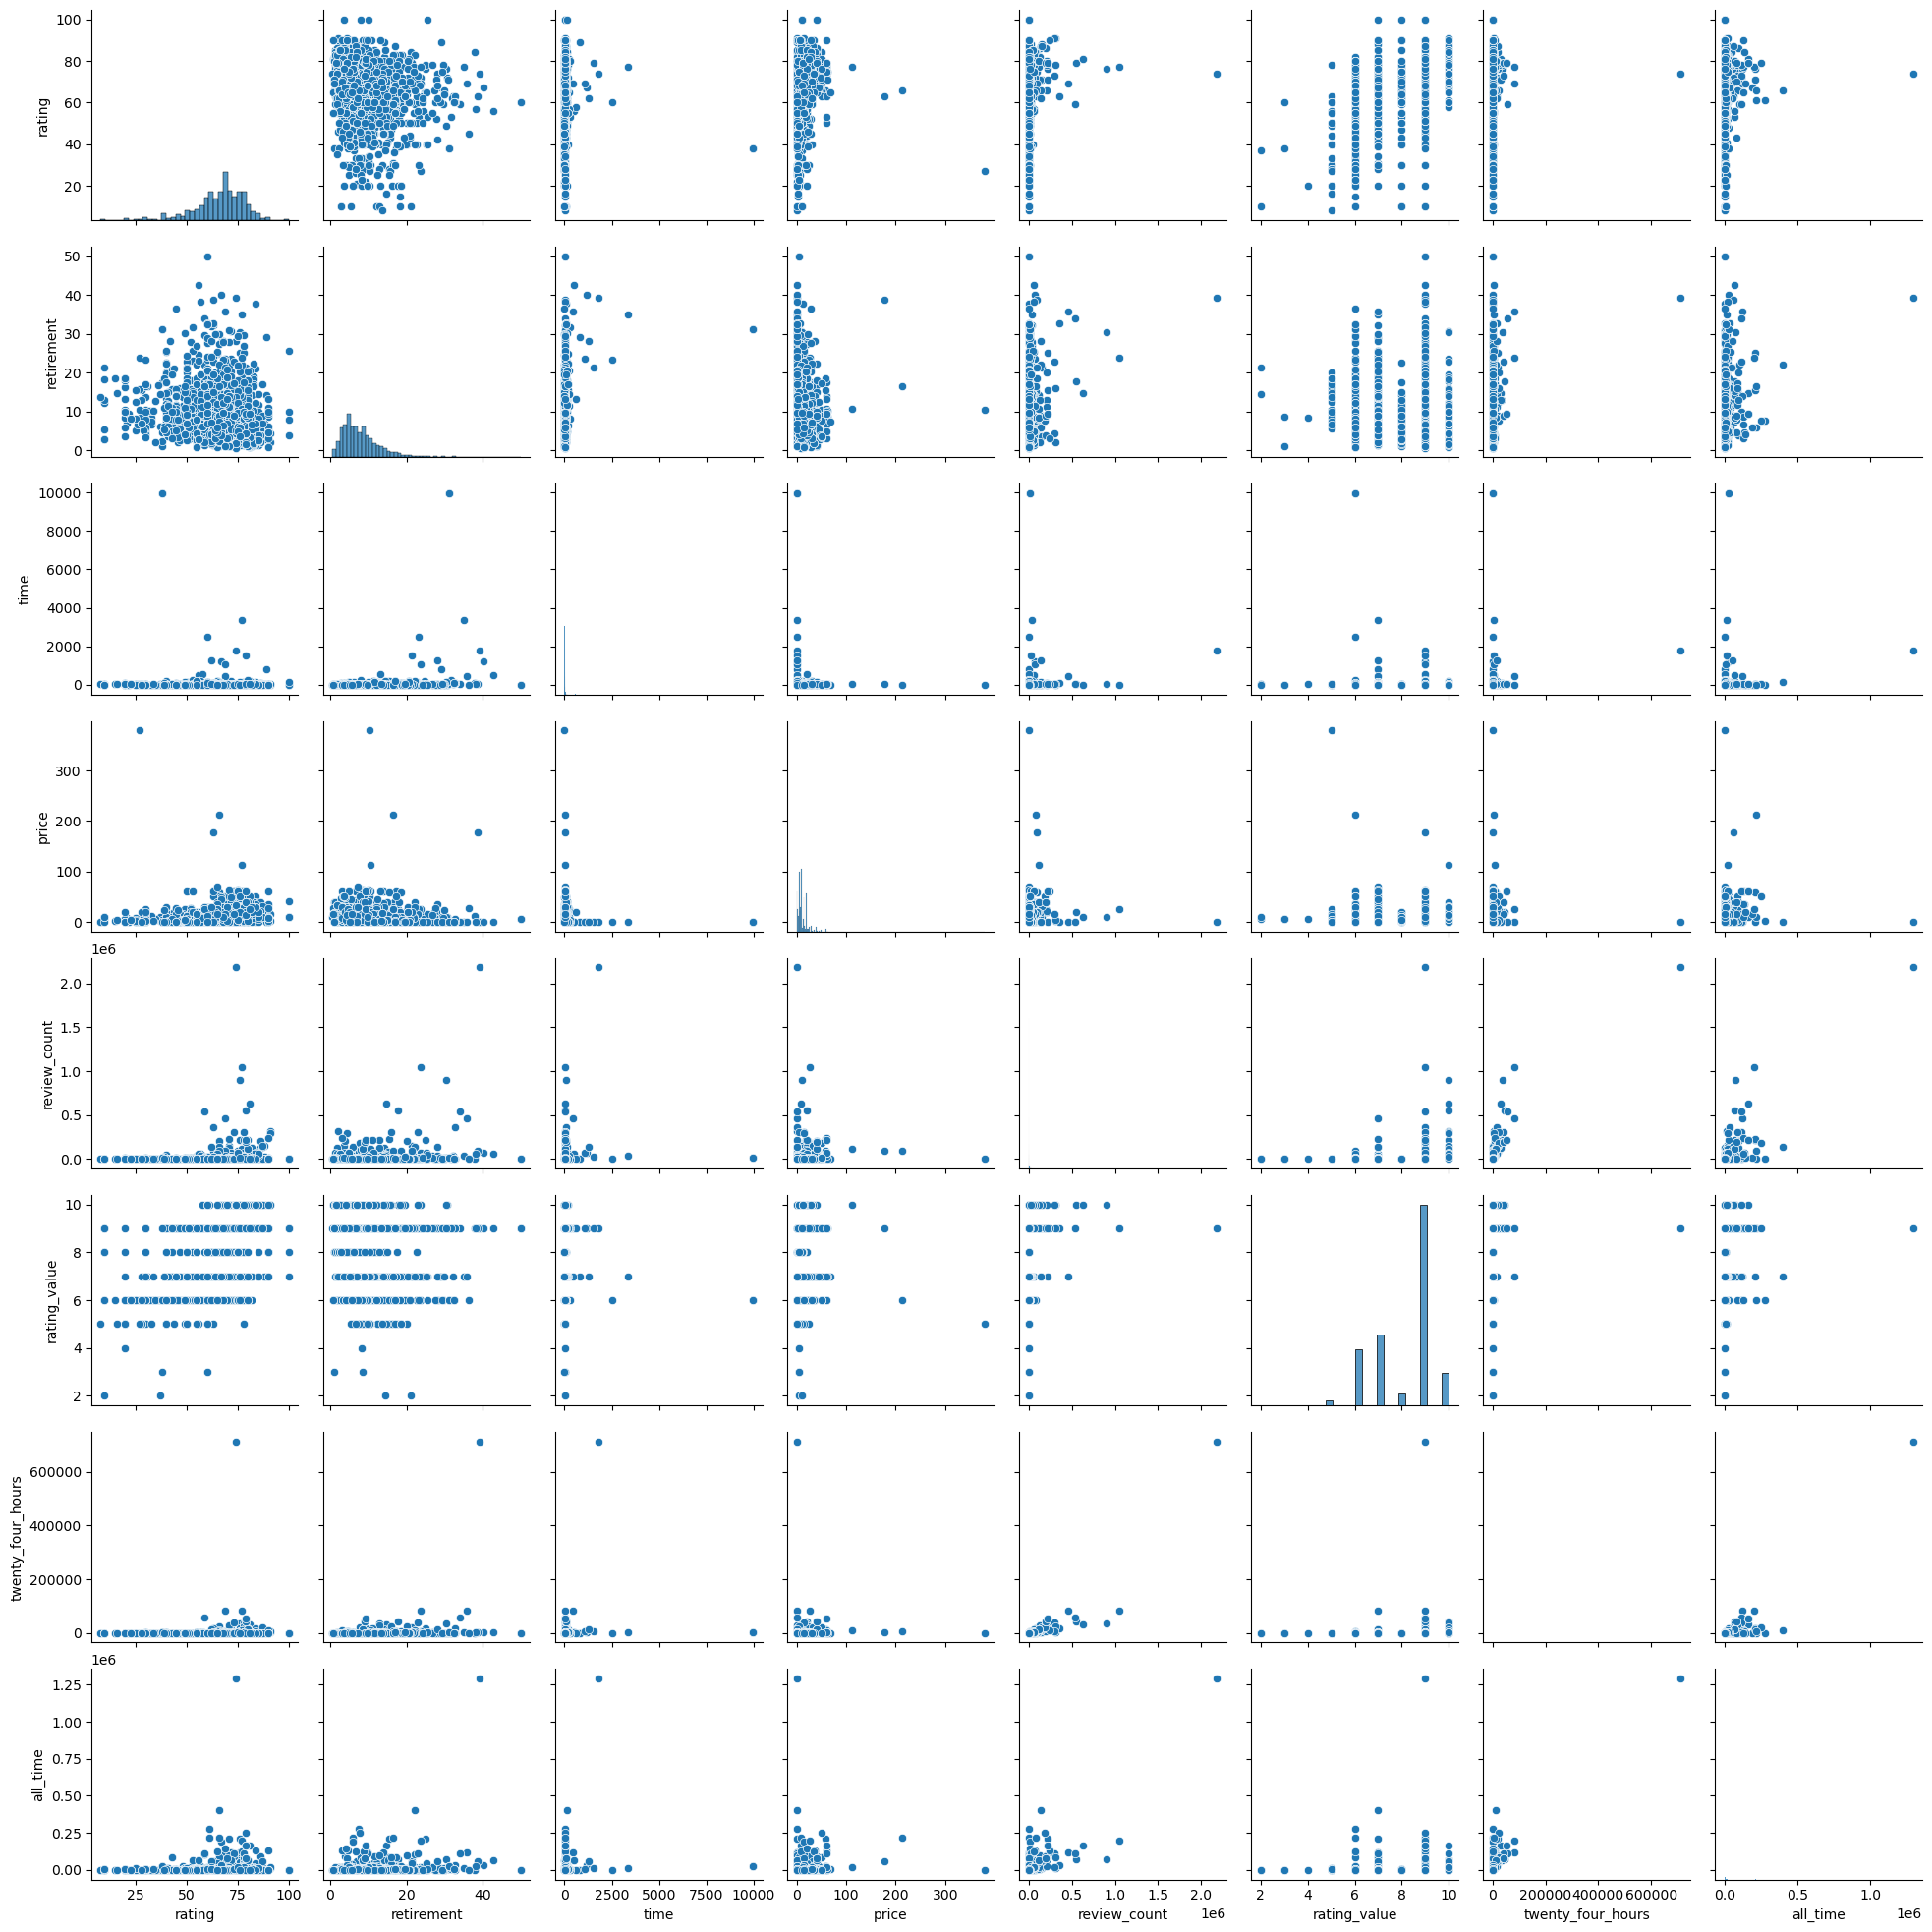

In [6]:
import numpy as np
import matplotlib.pyplot as plt

dfn.drop(index=np.where(outliers==-1)[0])

seaborn.pairplot(dfn)
plt.savefig("pairplot.png")

### Prédiction du rating en fonction du genre, de la platforme, de la date de sortie et du prix.

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score


# Preprocessing
X = df[['platform', 'genre', 'date', 'price']]
y = df['rating']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = list(y_train)
y_test = list(y_test)

# Define preprocessing steps
categorical_features = ['platform', 'genre']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline with preprocessing and linear regression model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

# Fit the model
model.fit(X_train, y_train)

# Predict ratings
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')


Mean Squared Error: 161.54521020529612
R-squared: -0.09306862114047432


-> modèle très mauvais

### Prédiction du retirement en fonction du rating, de la plateforme, du genre, de la date et du prix

In [37]:
from sklearn.ensemble import RandomForestRegressor

# Preprocessing
X = df[['rating', 'platform', 'genre', 'date', 'price']]
y = df['retirement']  # Assuming 'retirement' is the target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encode categorical features
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Ensure columns in X_train and X_test are aligned
X_train, X_test = X_train.align(X_test, join='outer', axis=1, fill_value=0)

# Train the Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict retirement on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')



Mean Squared Error: 21.206100644341795
R-squared: 0.26837598322983647


-> modèle pas ouf

In [130]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import ast

def dummies_list(df):
    df2 = pd.get_dummies(pd.DataFrame(df.values.tolist()), prefix_sep='', prefix='')
    merged_columns = {}
    for col_name, col_data in df2.items():
        if col_name.strip() not in merged_columns:
            merged_columns[col_name.strip()] = col_data
        else:
            merged_columns[col_name.strip()] += col_data
    merged_platform = pd.DataFrame(merged_columns)
    return merged_platform

# Preprocessing
X = df[['platform', 'genre', 'rating']]
X = X.dropna(axis="rows")
X['platform'] = X['platform'].astype(str).apply(ast.literal_eval) # certaines listes sont enregistrées en str donc on remet tout en listes
X['genre'] = X['genre'].astype(str).apply(ast.literal_eval)

X_platform = dummies_list(X.platform)
X_genre = dummies_list(X.genre)
X = X.drop(columns=["platform","genre"])
X = pd.merge(X,X_genre,left_index=True,right_index=True)
X = pd.merge(X,X_platform,left_index=True,right_index=True)

#scaler = StandardScaler()  # Standardize numerical variables
#X_scaled = scaler.fit_transform(X_encoded)



c:\Users\rapha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\rapha\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\rapha\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


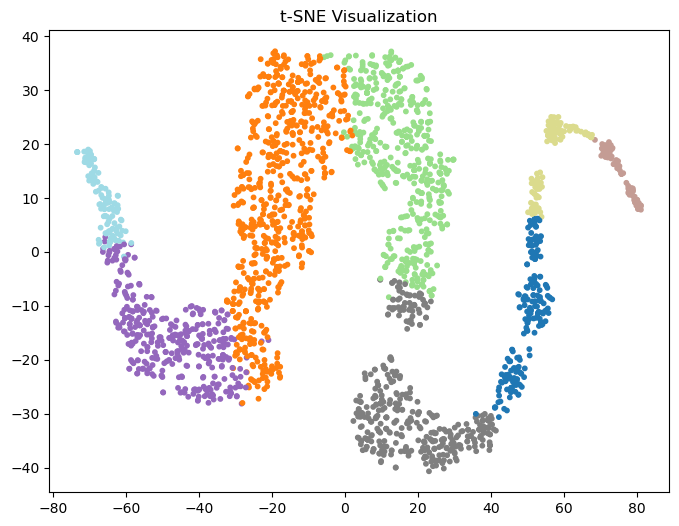

In [131]:
# t-SNE
from sklearn.manifold import TSNE

tab20 = plt.get_cmap('tab20')

km = KMeans(n_clusters=5)
km.n_clusters = 8
pred = km.fit_predict(X)

tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(X)
plt.figure(figsize=(8, 6))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=pred, cmap='tab20', s=10)
plt.title('t-SNE Visualization')
plt.show()